In [16]:
!pip install stable_baselines3 sb3_contrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 3.5 MB/s eta 0:00:00



         DQN FOR SWING TRADING (WITH HOLD STRATEGY)         

Loading data from reliance_30.csv...

[Feature Engineering Phase]
Selected 12 features across 4 categories
Train samples: 22226, Test samples: 5557

[Normalization Strategy]
✓ StandardScaler fitted on 2 stationary features
✓ RobustScaler fitted on 4 unbounded features
✓ MinMaxScaler configured for 4 bounded features
✓ Log + StandardScaler fitted on 2 ratio features

📊 Data Shape: Train=(22226, 12), Test=(5557, 12)
📈 Features: 12 (normalized by category)
🖥️  Using device: cuda
Episode   1/150 | Reward:   -27.19 | Loss: 0.0464 | Q-Val:  -0.08 | ε: 0.995 | Net Worth: $76,147 | Trades: 257
Episode  10/150 | Reward:   -30.19 | Loss: 0.0101 | Q-Val:  -0.14 | ε: 0.951 | Net Worth: $75,386 | Trades: 256
Episode  20/150 | Reward:   -27.55 | Loss: 0.0209 | Q-Val:  -0.14 | ε: 0.905 | Net Worth: $77,401 | Trades: 272
Episode  30/150 | Reward:   -19.02 | Loss: 0.0207 | Q-Val:  -0.13 | ε: 0.860 | Net Worth: $82,618 | Trades: 265
Episode 

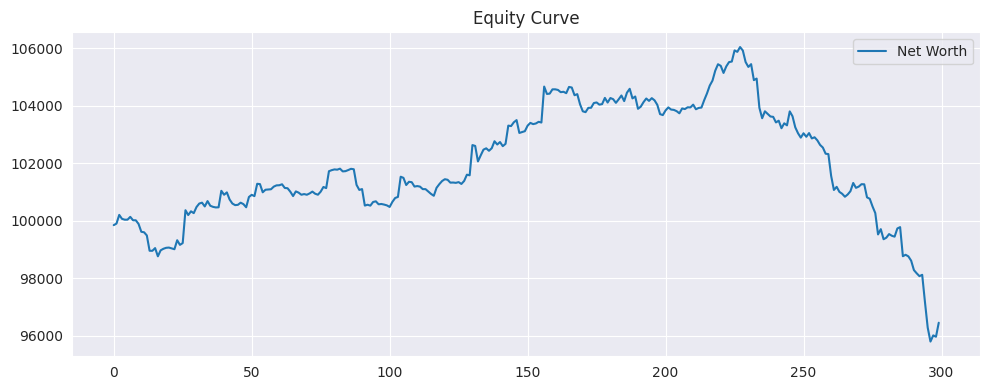

In [3]:
import gymnasium as gym
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from collections import deque
from sklearn.preprocessing import StandardScaler, RobustScaler

# Suppress warnings for clean output
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

# ==========================================
# 1. ADVANCED DATA PROCESSING & NORMALIZATION
# (unchanged from your prior code, trimmed for brevity where possible)
# ==========================================
class DataProcessor:
    def __init__(self):
        self.scalers = {}
        self.feature_stats = {}

    def process_data(self, filepath):
        print(f"Loading data from {filepath}...")
        try:
            df = pd.read_csv(filepath)
            df.columns = df.columns.str.strip().str.lower()

            if 'timestamp' in df.columns:
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df = df.sort_values('timestamp')

            # Ensure numeric
            cols = ['open', 'high', 'low', 'close', 'volume']
            for col in cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            # --- ADVANCED FEATURE ENGINEERING ---
            print("\n[Feature Engineering Phase]")

            df['Returns'] = df['close'].pct_change()
            df['Log_Returns'] = np.log(df['close'] / df['close'].shift(1))

            ema12 = df['close'].ewm(span=12, adjust=False).mean()
            ema26 = df['close'].ewm(span=26, adjust=False).mean()
            df['MACD'] = ema12 - ema26
            df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
            df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

            delta = df['close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / (loss + 1e-10)
            df['RSI'] = 100 - (100 / (1 + rs))

            low_14 = df['low'].rolling(window=14).min()
            high_14 = df['high'].rolling(window=14).max()
            df['Stochastic_K'] = 100 * (df['close'] - low_14) / (high_14 - low_14 + 1e-10)
            df['Stochastic_D'] = df['Stochastic_K'].rolling(window=3).mean()

            df['SMA_20'] = df['close'].rolling(20).mean()
            df['Std_20'] = df['close'].rolling(20).std()
            df['BB_Upper'] = df['SMA_20'] + (df['Std_20'] * 2)
            df['BB_Lower'] = df['SMA_20'] - (df['Std_20'] * 2)
            df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['SMA_20']
            df['BB_Position'] = (df['close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'] + 1e-10)

            high_low = df['high'] - df['low']
            high_close = np.abs(df['high'] - df['close'].shift())
            low_close = np.abs(df['low'] - df['close'].shift())
            ranges = pd.concat([high_low, high_close, low_close], axis=1)
            true_range = ranges.max(axis=1)
            df['ATR'] = true_range.rolling(14).mean()

            df['Volume_SMA'] = df['volume'].rolling(20).mean()
            df['Volume_Ratio'] = df['volume'] / (df['Volume_SMA'] + 1e-10)

            df['Price_SMA_20'] = df['close'].rolling(20).mean()
            df['Price_Distance'] = (df['close'] - df['Price_SMA_20']) / df['Price_SMA_20']

            df.dropna(inplace=True)
            df.reset_index(drop=True, inplace=True)

            feature_cols = {
                'stationary': ['Log_Returns', 'Returns'],
                'unbounded': ['MACD', 'MACD_Hist', 'ATR', 'Price_Distance'],
                'bounded': ['RSI', 'Stochastic_K', 'Stochastic_D', 'BB_Position'],
                'ratio': ['Volume_Ratio', 'BB_Width']
            }

            all_features = []
            for cat in feature_cols.values():
                all_features.extend(cat)

            print(f"Selected {len(all_features)} features across 4 categories")

            train_size = int(len(df) * 0.8)
            train_df = df.iloc[:train_size].copy()
            test_df = df.iloc[train_size:].copy()

            print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

            return train_df, test_df, all_features, feature_cols

        except FileNotFoundError:
            print("❌ CSV not found. Generating synthetic data for testing...")
            return self._generate_synthetic_data()

    def _generate_synthetic_data(self):
        np.random.seed(42)
        n_samples = 4000
        t = np.linspace(0, 50, n_samples)
        trend = 2000 + t * 10
        cycle = 100 * np.sin(t * 0.5)
        noise = np.random.normal(0, 20, n_samples)
        close = trend + cycle + noise

        dates = pd.date_range(start='2020-01-01', periods=n_samples, freq='30min')

        df = pd.DataFrame({
            'timestamp': dates,
            'open': close * (1 + np.random.uniform(-0.01, 0.01, n_samples)),
            'high': close * (1 + np.random.uniform(0, 0.02, n_samples)),
            'low': close * (1 - np.random.uniform(0, 0.02, n_samples)),
            'close': close,
            'volume': np.random.lognormal(10, 1, n_samples)
        })

        df.to_csv('synthetic_data.csv', index=False)
        print("✓ Synthetic data saved as 'synthetic_data.csv'")
        return self.process_data('synthetic_data.csv')

    def fit_normalizers(self, train_df, feature_cols_dict):
        print("\n[Normalization Strategy]")
        if 'stationary' in feature_cols_dict and feature_cols_dict['stationary']:
            self.scalers['stationary'] = StandardScaler()
            self.scalers['stationary'].fit(train_df[feature_cols_dict['stationary']])
            print(f"✓ StandardScaler fitted on {len(feature_cols_dict['stationary'])} stationary features")

        if 'unbounded' in feature_cols_dict and feature_cols_dict['unbounded']:
            self.scalers['unbounded'] = RobustScaler()
            self.scalers['unbounded'].fit(train_df[feature_cols_dict['unbounded']])
            print(f"✓ RobustScaler fitted on {len(feature_cols_dict['unbounded'])} unbounded features")

        if 'bounded' in feature_cols_dict and feature_cols_dict['bounded']:
            self.scalers['bounded'] = 'minmax'
            print(f"✓ MinMaxScaler configured for {len(feature_cols_dict['bounded'])} bounded features")

        if 'ratio' in feature_cols_dict and feature_cols_dict['ratio']:
            ratio_data = train_df[feature_cols_dict['ratio']].copy()
            ratio_data = np.log1p(ratio_data.clip(lower=0))
            self.scalers['ratio'] = StandardScaler()
            self.scalers['ratio'].fit(ratio_data)
            print(f"✓ Log + StandardScaler fitted on {len(feature_cols_dict['ratio'])} ratio features")

        self.feature_cols_dict = feature_cols_dict

    def transform(self, df):
        normalized_features = []

        if 'stationary' in self.feature_cols_dict:
            feats = self.feature_cols_dict['stationary']
            transformed = self.scalers['stationary'].transform(df[feats])
            normalized_features.append(transformed)

        if 'unbounded' in self.feature_cols_dict:
            feats = self.feature_cols_dict['unbounded']
            transformed = self.scalers['unbounded'].transform(df[feats])
            normalized_features.append(transformed)

        if 'bounded' in self.feature_cols_dict:
            feats = self.feature_cols_dict['bounded']
            transformed = (df[feats].values - 50) / 50
            normalized_features.append(transformed)

        if 'ratio' in self.feature_cols_dict:
            feats = self.feature_cols_dict['ratio']
            ratio_data = np.log1p(df[feats].values.clip(min=0))
            transformed = self.scalers['ratio'].transform(ratio_data)
            normalized_features.append(transformed)

        return np.hstack(normalized_features).astype(np.float32)


# ==========================================
# 2. DQN NETWORK (1D CNN Architecture)
# ==========================================
class DQN_Network(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_Network, self).__init__()
        n_features, seq_len = input_shape

        self.conv_layers = nn.Sequential(
            nn.Conv1d(n_features, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            nn.Flatten()
        )

        with th.no_grad():
            sample = th.randn(1, n_features, seq_len)
            conv_out_size = self.conv_layers(sample).shape[1]

        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        conv_out = self.conv_layers(x)
        value = self.value_stream(conv_out)
        advantages = self.advantage_stream(conv_out)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values


# ==========================================
# 3. PRIORITIZED EXPERIENCE REPLAY
# ==========================================
class PrioritizedReplayBuffer:
    def __init__(self, capacity=50000, alpha=0.6, beta=0.4, beta_increment=0.001):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        self.max_priority = 1.0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        buffer_len = len(self.buffer)
        priorities = self.priorities[:buffer_len]
        probs = priorities ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(buffer_len, batch_size, p=probs, replace=False)
        weights = (buffer_len * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        self.beta = min(1.0, self.beta + self.beta_increment)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones), indices, weights)

    def update_priorities(self, indices, td_errors):
        for idx, error in zip(indices, td_errors):
            priority = (abs(error) + 1e-6) ** self.alpha
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return len(self.buffer)


# ==========================================
# 4. DQN AGENT
# ==========================================
class DQNAgent:
    def __init__(self, state_shape, n_actions, lr=0.0001, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.device = th.device("cuda" if th.cuda.is_available() else "cpu")
        print(f"🖥️  Using device: {self.device}")

        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.policy_net = DQN_Network(state_shape, n_actions).to(self.device)
        self.target_net = DQN_Network(state_shape, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=30, gamma=0.5)

        self.replay_buffer = PrioritizedReplayBuffer(capacity=50000)
        self.batch_size = 128
        self.training_step = 0

    def select_action(self, state, training=True, valid_mask=None):
        if training and random.random() < self.epsilon:
            if valid_mask is not None:
                valid_actions = np.where(valid_mask == 1)[0]
                if len(valid_actions) > 0:
                    return np.random.choice(valid_actions)
            return random.randrange(self.n_actions)

        with th.no_grad():
            state_tensor = th.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor).cpu().numpy()[0]
            if valid_mask is not None:
                q_values = q_values.copy()
                q_values[valid_mask == 0] = -1e9
            return int(q_values.argmax())

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size * 2:
            return 0.0, 0.0

        states, actions, rewards, next_states, dones, indices, weights = \
            self.replay_buffer.sample(self.batch_size)

        states = th.FloatTensor(states).to(self.device)
        actions = th.LongTensor(actions).to(self.device)
        rewards = th.FloatTensor(rewards).to(self.device)
        next_states = th.FloatTensor(next_states).to(self.device)
        dones = th.FloatTensor(dones).to(self.device)
        weights = th.FloatTensor(weights).to(self.device)

        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

        with th.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + (1 - dones) * self.gamma * next_q

        td_errors = (target_q - current_q).detach().cpu().numpy()
        self.replay_buffer.update_priorities(indices, td_errors)

        loss = (weights * (current_q - target_q).pow(2)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        th.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10.0)
        self.optimizer.step()

        self.training_step += 1

        return loss.item(), current_q.mean().item()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def save(self, filepath):
        th.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, filepath)

    def load(self, filepath):
        checkpoint = th.load(filepath)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']


# ==========================================
# 5. SWING TRADING ENVIRONMENT (FIXED)
# ==========================================
class SwingTradingEnv(gym.Env):
    """
    Updates:
    - use positional indexing (.iloc) for prices to avoid KeyError
    - max_episode_steps to limit episode length
    - min_hold_period to avoid immediate reverse trades (enforces strategy / hold)
    - get_valid_actions returns mask that allows holding and disallows immediate reverse
    """
    def __init__(self, df, normalized_features, initial_balance=100000,
                 max_drawdown=0.3, commission=0.001, slippage=0.0005,
                 lookback_window=60, max_episode_steps=300, min_hold_period=5):
        super(SwingTradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.normalized_features = normalized_features
        self.initial_balance = initial_balance
        self.max_drawdown = max_drawdown
        self.commission = commission
        self.slippage = slippage

        # Actions: 0=SHORT, 1=NEUTRAL, 2=LONG
        self.action_space = gym.spaces.Discrete(3)

        self.lookback_window = lookback_window
        n_features = normalized_features.shape[1]
        self.observation_space = gym.spaces.Box(
            low=-10, high=10,
            shape=(n_features, self.lookback_window),
            dtype=np.float32
        )

        self.current_position = 1  # start NEUTRAL
        self.max_episode_steps = max_episode_steps
        self.min_hold_period = min_hold_period

        # runtime trackers
        self.last_trade_step = None
        self.step_count = 0

        # bookkeeping
        self.trades_count = 0

    def reset(self, seed=None):
        self.current_step = self.lookback_window
        self.balance = self.initial_balance
        self.shares = 0.0
        self.net_worth = self.initial_balance
        self.peak_net_worth = self.initial_balance
        self.trades_count = 0
        self.current_position = 1  # NEUTRAL
        self.last_trade_step = -9999
        self.step_count = 0

        self.history = {
            'net_worth': [],
            'action': [],
            'positions': [],
            'returns': []
        }

        return self._get_observation(), {}

    def _get_observation(self):
        start_idx = self.current_step - self.lookback_window
        end_idx = self.current_step
        obs = self.normalized_features[start_idx:end_idx].T
        return obs.astype(np.float32)

    def _get_current_position(self):
        if self.shares > 0.01:
            return 2  # LONG
        elif self.shares < -0.01:
            return 0  # SHORT
        else:
            return 1  # NEUTRAL

    def get_valid_actions(self):
        """
        Return mask [short, neutral, long] where 1=allowed, 0=forbidden.
        Rules:
         - Always allow holding the current position (i.e., taking same action as current position)
         - Disallow immediate reversal (SHORT <-> LONG) within min_hold_period after a trade
         - Neutral always allowed
        """
        mask = np.ones(3, dtype=np.float32)
        curr_pos = self._get_current_position()

        # find opposite action mapping
        opposite = {0: 2, 2: 0, 1: None}

        # If we've recently traded, and within min_hold_period, disallow reversing
        if (self.last_trade_step is not None) and (self.current_step - self.last_trade_step < self.min_hold_period):
            # disallow opposite of current position
            opp = opposite.get(curr_pos, None)
            if opp is not None:
                mask[opp] = 0.0

        # Always allow the current position (hold)
        # (mask stays 1 for curr_pos)
        return mask

    def step(self, action):
        # Use positional index to avoid KeyError
        current_price = float(self.df['close'].iloc[self.current_step])
        prev_net_worth = self.net_worth

        valid_mask = self.get_valid_actions()

        # If chosen action is invalid, penalize and step forward
        if valid_mask[action] == 0:
            reward = -1.0
            self.current_step += 1
            self.step_count += 1
            terminated = self.current_step >= len(self.df) - 1 or self.step_count >= self.max_episode_steps

            self.history['net_worth'].append(self.net_worth)
            self.history['action'].append(action)
            self.history['positions'].append(self.shares)
            self.history['returns'].append(0.0)

            return self._get_observation(), reward, terminated, False, {'valid_mask': valid_mask}

        # Position sizing (100% equity)
        target_shares = 0.0
        if action == 2:
            target_shares = self.net_worth / current_price
        elif action == 0:
            target_shares = -(self.net_worth / current_price)
        elif action == 1:
            target_shares = 0.0

        shares_diff = target_shares - self.shares

        if abs(shares_diff) > 1e-6:
            # apply slippage on execution price
            execution_price = current_price * (1 + self.slippage * np.sign(shares_diff))
            trade_value = abs(shares_diff) * execution_price
            transaction_cost = trade_value * self.commission

            self.shares += shares_diff
            self.balance -= (shares_diff * execution_price)
            self.balance -= transaction_cost

            # record trade time
            self.last_trade_step = self.current_step
            self.trades_count += 1

        # Update pos and net worth
        self.current_position = self._get_current_position()
        self.net_worth = self.balance + (self.shares * current_price)

        # Peak update
        if self.net_worth > self.peak_net_worth:
            self.peak_net_worth = self.net_worth

        # reward as percentage return scaled
        ret = (self.net_worth - prev_net_worth) / max(prev_net_worth, 1)
        reward = ret * 100.0
        reward = np.clip(reward, -10.0, 10.0)
        if ret < -0.01:
            reward -= 2.0

        # step counters and termination
        self.current_step += 1
        self.step_count += 1
        terminated = self.current_step >= len(self.df) - 1 or self.step_count >= self.max_episode_steps

        # check max drawdown
        drawdown = (self.peak_net_worth - self.net_worth) / max(self.peak_net_worth, 1)
        if drawdown > self.max_drawdown:
            terminated = True
            reward = -20.0

        # history
        self.history['net_worth'].append(self.net_worth)
        self.history['action'].append(int(action))
        self.history['positions'].append(self.shares)
        self.history['returns'].append(float(ret))

        return self._get_observation(), float(reward), bool(terminated), False, {'valid_mask': valid_mask}


# ==========================================
# 6. TRAINING & EVALUATION PIPELINE (MAIN)
# ==========================================
def calculate_metrics(net_worths, returns_series):
    nw = pd.Series(net_worths)
    returns = returns_series
    total_return = (nw.iloc[-1] - nw.iloc[0]) / nw.iloc[0] * 100
    n_periods = len(nw)
    n_years = n_periods / (12 * 252)
    annualized_return = ((nw.iloc[-1] / nw.iloc[0]) ** (1 / max(n_years, 0.01)) - 1) * 100
    mean_return = returns.mean()
    std_return = returns.std()
    sharpe = (mean_return / std_return) * np.sqrt(12 * 252) if std_return > 0 else 0
    negative_returns = returns[returns < 0]
    downside_std = negative_returns.std()
    sortino = (mean_return / downside_std) * np.sqrt(12 * 252) if len(negative_returns) > 0 else 0
    running_max = nw.cummax()
    drawdowns = (nw - running_max) / running_max
    max_drawdown = drawdowns.min() * 100
    calmar = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    win_rate = (returns > 0).sum() / len(returns) * 100 if len(returns) > 0 else 0
    gross_profit = returns[returns > 0].sum()
    gross_loss = abs(returns[returns < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
    volatility = std_return * np.sqrt(12 * 252) * 100

    return {
        'Total Return (%)': total_return,
        'Annualized Return (%)': annualized_return,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown (%)': max_drawdown,
        'Calmar Ratio': calmar,
        'Win Rate (%)': win_rate,
        'Profit Factor': profit_factor,
        'Volatility (%)': volatility
    }


# ==========================================
# 7. MAIN TRAINING PIPELINE (run)
# ==========================================
if __name__ == "__main__":
    print("\n" + "="*60)
    print(" DQN FOR SWING TRADING (WITH HOLD STRATEGY) ".center(60))
    print("="*60 + "\n")

    # Data processing
    processor = DataProcessor()
    filename = "reliance_30.csv"
    train_df, test_df, all_features, feature_cols_dict = processor.process_data(filename)

    if train_df is not None:
        processor.fit_normalizers(train_df, feature_cols_dict)
        train_normalized = processor.transform(train_df)
        test_normalized = processor.transform(test_df)

        print(f"\n📊 Data Shape: Train={train_normalized.shape}, Test={test_normalized.shape}")
        print(f"📈 Features: {len(all_features)} (normalized by category)")

        # Env parameters: you can tune these
        LOOKBACK = 60
        MAX_EPISODE_STEPS = 300    # <-- episode length (you asked to add episode length)
        MIN_HOLD = 5               # <-- min holding period to avoid flip-flop trades

        train_env = SwingTradingEnv(train_df, train_normalized,
                                    lookback_window=LOOKBACK,
                                    max_episode_steps=MAX_EPISODE_STEPS,
                                    min_hold_period=MIN_HOLD)
        test_env = SwingTradingEnv(test_df, test_normalized,
                                   lookback_window=LOOKBACK,
                                   max_episode_steps=MAX_EPISODE_STEPS,
                                   min_hold_period=MIN_HOLD)

        state_shape = (train_normalized.shape[1], train_env.lookback_window)
        n_actions = train_env.action_space.n

        agent = DQNAgent(state_shape=state_shape, n_actions=n_actions,
                         lr=0.0001, gamma=0.99,
                         epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995)

        # Training loop (kept similar)
        num_episodes = 150
        target_update_freq = 10
        best_reward = -np.inf
        training_rewards = []
        training_losses = []

        for episode in range(num_episodes):
            state, _ = train_env.reset()
            episode_reward = 0.0
            episode_losses = []
            episode_q_values = []
            done = False

            while not done:
                valid_mask = train_env.get_valid_actions()
                action = agent.select_action(state, training=True, valid_mask=valid_mask)
                next_state, reward, done, _, info = train_env.step(action)

                agent.replay_buffer.push(state, action, reward, next_state, done)
                loss, q_val = agent.train_step()
                if loss > 0:
                    episode_losses.append(loss)
                    episode_q_values.append(q_val)

                state = next_state
                episode_reward += reward

            if episode % target_update_freq == 0:
                agent.update_target_network()
                agent.scheduler.step()

            agent.decay_epsilon()
            training_rewards.append(episode_reward)
            avg_loss = np.mean(episode_losses) if episode_losses else 0
            training_losses.append(avg_loss)

            if episode_reward > best_reward:
                best_reward = episode_reward
                agent.save('best_dqn_model.pth')

            if (episode + 1) % 10 == 0 or episode == 0:
                print(f"Episode {episode+1:3d}/{num_episodes} | "
                      f"Reward: {episode_reward:8.2f} | "
                      f"Loss: {avg_loss:6.4f} | "
                      f"Q-Val: {np.mean(episode_q_values) if episode_q_values else 0:6.2f} | "
                      f"ε: {agent.epsilon:.3f} | "
                      f"Net Worth: ${train_env.net_worth:,.0f} | "
                      f"Trades: {train_env.trades_count}")

        # Evaluation
        agent.load('best_dqn_model.pth')
        state, _ = test_env.reset()
        done = False
        while not done:
            valid_mask = test_env.get_valid_actions()
            action = agent.select_action(state, training=False, valid_mask=valid_mask)
            state, reward, done, _, _ = test_env.step(action)

        net_worths = test_env.history['net_worth']
        returns = pd.Series(test_env.history['returns'])
        metrics = calculate_metrics(net_worths, returns)

        # Print & visualize (same as before)
        print("\n" + "="*60)
        print(" PERFORMANCE METRICS ".center(60))
        print("="*60)
        print(f"Final Balance: ${net_worths[-1]:,.2f}")
        for metric, value in metrics.items():
            print(f"{metric:<25} {value:>12.4f}" if isinstance(value, float) else f"{metric:<25} {value}")

        # Save a quick plot
        plt.figure(figsize=(10, 4))
        plt.plot(net_worths, label='Net Worth')
        plt.title('Equity Curve')
        plt.legend()
        plt.tight_layout()
        plt.savefig('DQN_Research_Report_fixed.png')
        print("\nSaved report: DQN_Research_Report_fixed.png")

        print("\n✅ Done. Changes applied: positional indexing, episode length, and hold-strategy.")




         DQN FOR SWING TRADING (WITH HOLD STRATEGY)         

Loading data from reliance_30.csv...

[Feature Engineering Phase]
Selected 12 features across 4 categories
Train samples: 22226, Test samples: 5557

[Normalization Strategy]
✓ StandardScaler fitted on 2 stationary features
✓ RobustScaler fitted on 4 unbounded features
✓ MinMaxScaler configured for 4 bounded features
✓ Log + StandardScaler fitted on 2 ratio features

📊 Data Shape: Train=(22226, 12), Test=(5557, 12)
📈 Features: 12 (normalized by category)
🖥️  Using device: cuda
Episode   1/150 | Reward:   -32.82 | Loss: 0.0502 | Q-Val:  -0.16 | ε: 0.995 | Net Worth: $73,427 | Trades: 264
Episode  10/150 | Reward:   -27.56 | Loss: 0.0082 | Q-Val:  -0.17 | ε: 0.951 | Net Worth: $75,862 | Trades: 252
Episode  20/150 | Reward:   -25.79 | Loss: 0.0097 | Q-Val:  -0.18 | ε: 0.905 | Net Worth: $77,207 | Trades: 263
Episode  30/150 | Reward:   -29.26 | Loss: 0.0100 | Q-Val:  -0.16 | ε: 0.860 | Net Worth: $76,090 | Trades: 259
Episode 

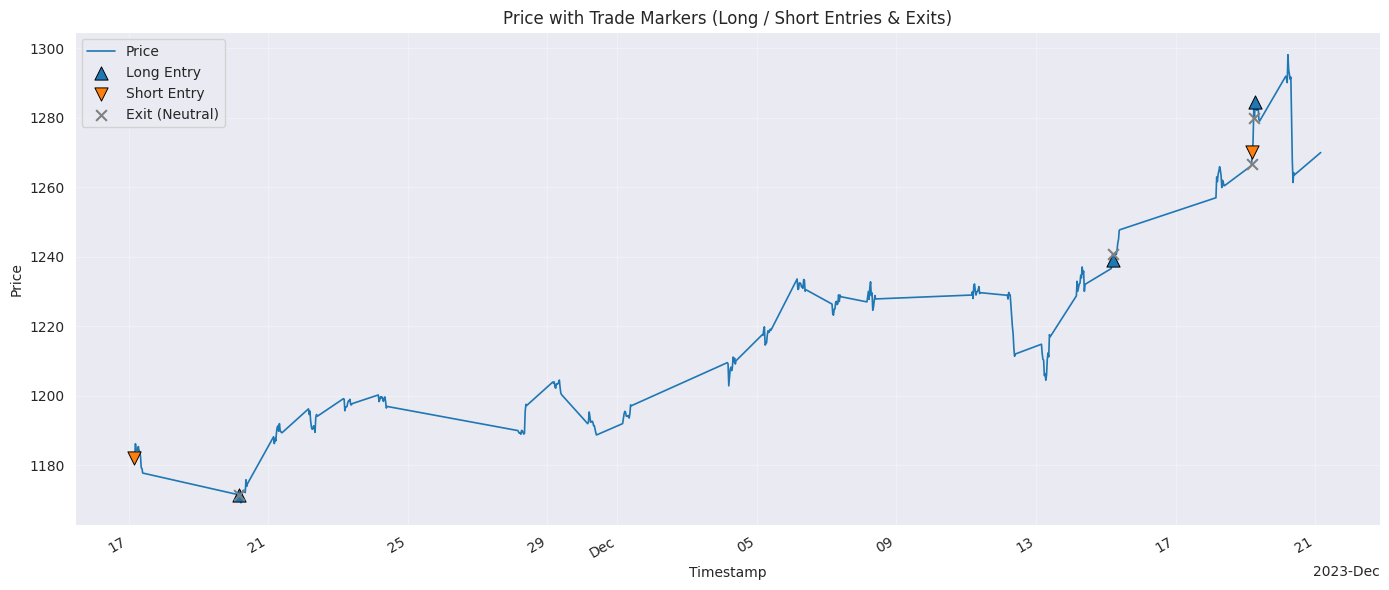


✅ Done. Trade markers plotted on the price chart.


In [5]:
import gymnasium as gym
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import random
from sklearn.preprocessing import StandardScaler, RobustScaler

# Suppress warnings for clean output
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

# ==========================================
# 1. ADVANCED DATA PROCESSING & NORMALIZATION
# ==========================================
class DataProcessor:
    def __init__(self):
        self.scalers = {}
        self.feature_stats = {}

    def process_data(self, filepath):
        print(f"Loading data from {filepath}...")
        try:
            df = pd.read_csv(filepath)
            df.columns = df.columns.str.strip().str.lower()

            if 'timestamp' in df.columns:
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df = df.sort_values('timestamp')

            # Ensure numeric
            cols = ['open', 'high', 'low', 'close', 'volume']
            for col in cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

            print("\n[Feature Engineering Phase]")

            df['Returns'] = df['close'].pct_change()
            df['Log_Returns'] = np.log(df['close'] / df['close'].shift(1))

            ema12 = df['close'].ewm(span=12, adjust=False).mean()
            ema26 = df['close'].ewm(span=26, adjust=False).mean()
            df['MACD'] = ema12 - ema26
            df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
            df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

            delta = df['close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / (loss + 1e-10)
            df['RSI'] = 100 - (100 / (1 + rs))

            low_14 = df['low'].rolling(window=14).min()
            high_14 = df['high'].rolling(window=14).max()
            df['Stochastic_K'] = 100 * (df['close'] - low_14) / (high_14 - low_14 + 1e-10)
            df['Stochastic_D'] = df['Stochastic_K'].rolling(window=3).mean()

            df['SMA_20'] = df['close'].rolling(20).mean()
            df['Std_20'] = df['close'].rolling(20).std()
            df['BB_Upper'] = df['SMA_20'] + (df['Std_20'] * 2)
            df['BB_Lower'] = df['SMA_20'] - (df['Std_20'] * 2)
            df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['SMA_20']
            df['BB_Position'] = (df['close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'] + 1e-10)

            high_low = df['high'] - df['low']
            high_close = np.abs(df['high'] - df['close'].shift())
            low_close = np.abs(df['low'] - df['close'].shift())
            ranges = pd.concat([high_low, high_close, low_close], axis=1)
            true_range = ranges.max(axis=1)
            df['ATR'] = true_range.rolling(14).mean()

            df['Volume_SMA'] = df['volume'].rolling(20).mean()
            df['Volume_Ratio'] = df['volume'] / (df['Volume_SMA'] + 1e-10)

            df['Price_SMA_20'] = df['close'].rolling(20).mean()
            df['Price_Distance'] = (df['close'] - df['Price_SMA_20']) / df['Price_SMA_20']

            df.dropna(inplace=True)
            df.reset_index(drop=True, inplace=True)

            feature_cols = {
                'stationary': ['Log_Returns', 'Returns'],
                'unbounded': ['MACD', 'MACD_Hist', 'ATR', 'Price_Distance'],
                'bounded': ['RSI', 'Stochastic_K', 'Stochastic_D', 'BB_Position'],
                'ratio': ['Volume_Ratio', 'BB_Width']
            }

            all_features = []
            for cat in feature_cols.values():
                all_features.extend(cat)

            print(f"Selected {len(all_features)} features across 4 categories")

            train_size = int(len(df) * 0.8)
            train_df = df.iloc[:train_size].copy()
            test_df = df.iloc[train_size:].copy()

            print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

            return train_df, test_df, all_features, feature_cols

        except FileNotFoundError:
            print("❌ CSV not found. Generating synthetic data for testing...")
            return self._generate_synthetic_data()

    def _generate_synthetic_data(self):
        np.random.seed(42)
        n_samples = 4000
        t = np.linspace(0, 50, n_samples)
        trend = 2000 + t * 10
        cycle = 100 * np.sin(t * 0.5)
        noise = np.random.normal(0, 20, n_samples)
        close = trend + cycle + noise

        dates = pd.date_range(start='2020-01-01', periods=n_samples, freq='30min')

        df = pd.DataFrame({
            'timestamp': dates,
            'open': close * (1 + np.random.uniform(-0.01, 0.01, n_samples)),
            'high': close * (1 + np.random.uniform(0, 0.02, n_samples)),
            'low': close * (1 - np.random.uniform(0, 0.02, n_samples)),
            'close': close,
            'volume': np.random.lognormal(10, 1, n_samples)
        })

        df.to_csv('synthetic_data.csv', index=False)
        print("✓ Synthetic data saved as 'synthetic_data.csv'")
        return self.process_data('synthetic_data.csv')

    def fit_normalizers(self, train_df, feature_cols_dict):
        print("\n[Normalization Strategy]")
        if 'stationary' in feature_cols_dict and feature_cols_dict['stationary']:
            self.scalers['stationary'] = StandardScaler()
            self.scalers['stationary'].fit(train_df[feature_cols_dict['stationary']])
            print(f"✓ StandardScaler fitted on {len(feature_cols_dict['stationary'])} stationary features")

        if 'unbounded' in feature_cols_dict and feature_cols_dict['unbounded']:
            self.scalers['unbounded'] = RobustScaler()
            self.scalers['unbounded'].fit(train_df[feature_cols_dict['unbounded']])
            print(f"✓ RobustScaler fitted on {len(feature_cols_dict['unbounded'])} unbounded features")

        if 'bounded' in feature_cols_dict and feature_cols_dict['bounded']:
            self.scalers['bounded'] = 'minmax'
            print(f"✓ MinMaxScaler configured for {len(feature_cols_dict['bounded'])} bounded features")

        if 'ratio' in feature_cols_dict and feature_cols_dict['ratio']:
            ratio_data = train_df[feature_cols_dict['ratio']].copy()
            ratio_data = np.log1p(ratio_data.clip(lower=0))
            self.scalers['ratio'] = StandardScaler()
            self.scalers['ratio'].fit(ratio_data)
            print(f"✓ Log + StandardScaler fitted on {len(feature_cols_dict['ratio'])} ratio features")

        self.feature_cols_dict = feature_cols_dict

    def transform(self, df):
        normalized_features = []

        if 'stationary' in self.feature_cols_dict:
            feats = self.feature_cols_dict['stationary']
            transformed = self.scalers['stationary'].transform(df[feats])
            normalized_features.append(transformed)

        if 'unbounded' in self.feature_cols_dict:
            feats = self.feature_cols_dict['unbounded']
            transformed = self.scalers['unbounded'].transform(df[feats])
            normalized_features.append(transformed)

        if 'bounded' in self.feature_cols_dict:
            feats = self.feature_cols_dict['bounded']
            transformed = (df[feats].values - 50) / 50
            normalized_features.append(transformed)

        if 'ratio' in self.feature_cols_dict:
            feats = self.feature_cols_dict['ratio']
            ratio_data = np.log1p(df[feats].values.clip(min=0))
            transformed = self.scalers['ratio'].transform(ratio_data)
            normalized_features.append(transformed)

        return np.hstack(normalized_features).astype(np.float32)


# ==========================================
# 2. DQN NETWORK (1D CNN Architecture)
# ==========================================
class DQN_Network(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_Network, self).__init__()
        n_features, seq_len = input_shape

        self.conv_layers = nn.Sequential(
            nn.Conv1d(n_features, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),

            nn.Flatten()
        )

        with th.no_grad():
            sample = th.randn(1, n_features, seq_len)
            conv_out_size = self.conv_layers(sample).shape[1]

        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_actions)
        )

    def forward(self, x):
        conv_out = self.conv_layers(x)
        value = self.value_stream(conv_out)
        advantages = self.advantage_stream(conv_out)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values


# ==========================================
# 3. PRIORITIZED EXPERIENCE REPLAY
# ==========================================
class PrioritizedReplayBuffer:
    def __init__(self, capacity=50000, alpha=0.6, beta=0.4, beta_increment=0.001):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.buffer = []
        self.priorities = np.zeros(capacity, dtype=np.float32)
        self.position = 0
        self.max_priority = 1.0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        buffer_len = len(self.buffer)
        priorities = self.priorities[:buffer_len]
        probs = priorities ** self.alpha
        probs /= probs.sum()
        indices = np.random.choice(buffer_len, batch_size, p=probs, replace=False)
        weights = (buffer_len * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        self.beta = min(1.0, self.beta + self.beta_increment)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones), indices, weights)

    def update_priorities(self, indices, td_errors):
        for idx, error in zip(indices, td_errors):
            priority = (abs(error) + 1e-6) ** self.alpha
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return len(self.buffer)


# ==========================================
# 4. DQN AGENT
# ==========================================
class DQNAgent:
    def __init__(self, state_shape, n_actions, lr=0.0001, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.device = th.device("cuda" if th.cuda.is_available() else "cpu")
        print(f"🖥️  Using device: {self.device}")

        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.policy_net = DQN_Network(state_shape, n_actions).to(self.device)
        self.target_net = DQN_Network(state_shape, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=30, gamma=0.5)

        self.replay_buffer = PrioritizedReplayBuffer(capacity=50000)
        self.batch_size = 128
        self.training_step = 0

    def select_action(self, state, training=True, valid_mask=None):
        if training and random.random() < self.epsilon:
            if valid_mask is not None:
                valid_actions = np.where(valid_mask == 1)[0]
                if len(valid_actions) > 0:
                    return int(np.random.choice(valid_actions))
            return int(random.randrange(self.n_actions))

        with th.no_grad():
            state_tensor = th.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor).cpu().numpy()[0]
            if valid_mask is not None:
                q_values = q_values.copy()
                q_values[valid_mask == 0] = -1e9
            return int(q_values.argmax())

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size * 2:
            return 0.0, 0.0

        states, actions, rewards, next_states, dones, indices, weights = \
            self.replay_buffer.sample(self.batch_size)

        states = th.FloatTensor(states).to(self.device)
        actions = th.LongTensor(actions).to(self.device)
        rewards = th.FloatTensor(rewards).to(self.device)
        next_states = th.FloatTensor(next_states).to(self.device)
        dones = th.FloatTensor(dones).to(self.device)
        weights = th.FloatTensor(weights).to(self.device)

        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze()

        with th.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            next_q = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            target_q = rewards + (1 - dones) * self.gamma * next_q

        td_errors = (target_q - current_q).detach().cpu().numpy()
        self.replay_buffer.update_priorities(indices, td_errors)

        loss = (weights * (current_q - target_q).pow(2)).mean()

        self.optimizer.zero_grad()
        loss.backward()
        th.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10.0)
        self.optimizer.step()

        self.training_step += 1

        return loss.item(), current_q.mean().item()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

    def save(self, filepath):
        th.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, filepath)

    def load(self, filepath):
        checkpoint = th.load(filepath)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']


# ==========================================
# 5. SWING TRADING ENVIRONMENT
# ==========================================
class SwingTradingEnv(gym.Env):
    def __init__(self, df, normalized_features, initial_balance=100000,
                 max_drawdown=0.3, commission=0.001, slippage=0.0005,
                 lookback_window=60, max_episode_steps=300, min_hold_period=5):
        super(SwingTradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.normalized_features = normalized_features
        self.initial_balance = initial_balance
        self.max_drawdown = max_drawdown
        self.commission = commission
        self.slippage = slippage

        self.action_space = gym.spaces.Discrete(3)

        self.lookback_window = lookback_window
        n_features = normalized_features.shape[1]
        self.observation_space = gym.spaces.Box(
            low=-10, high=10,
            shape=(n_features, self.lookback_window),
            dtype=np.float32
        )

        self.current_position = 1  # start NEUTRAL
        self.max_episode_steps = max_episode_steps
        self.min_hold_period = min_hold_period

        self.last_trade_step = None
        self.step_count = 0
        self.trades_count = 0

    def reset(self, seed=None):
        self.current_step = self.lookback_window
        self.balance = self.initial_balance
        self.shares = 0.0
        self.net_worth = self.initial_balance
        self.peak_net_worth = self.initial_balance
        self.trades_count = 0
        self.current_position = 1  # NEUTRAL
        self.last_trade_step = -9999
        self.step_count = 0

        self.history = {
            'net_worth': [],
            'action': [],
            'positions': [],
            'returns': []
        }

        return self._get_observation(), {}

    def _get_observation(self):
        start_idx = self.current_step - self.lookback_window
        end_idx = self.current_step
        obs = self.normalized_features[start_idx:end_idx].T
        return obs.astype(np.float32)

    def _get_current_position(self):
        if self.shares > 0.01:
            return 2  # LONG
        elif self.shares < -0.01:
            return 0  # SHORT
        else:
            return 1  # NEUTRAL

    def get_valid_actions(self):
        mask = np.ones(3, dtype=np.float32)
        curr_pos = self._get_current_position()
        opposite = {0: 2, 2: 0, 1: None}
        if (self.last_trade_step is not None) and (self.current_step - self.last_trade_step < self.min_hold_period):
            opp = opposite.get(curr_pos, None)
            if opp is not None:
                mask[opp] = 0.0
        return mask

    def step(self, action):
        current_price = float(self.df['close'].iloc[self.current_step])
        prev_net_worth = self.net_worth

        valid_mask = self.get_valid_actions()

        if valid_mask[action] == 0:
            reward = -1.0
            self.current_step += 1
            self.step_count += 1
            terminated = self.current_step >= len(self.df) - 1 or self.step_count >= self.max_episode_steps

            self.history['net_worth'].append(self.net_worth)
            self.history['action'].append(int(action))
            self.history['positions'].append(self.shares)
            self.history['returns'].append(0.0)

            return self._get_observation(), reward, terminated, False, {'valid_mask': valid_mask}

        target_shares = 0.0
        if action == 2:
            target_shares = self.net_worth / current_price
        elif action == 0:
            target_shares = -(self.net_worth / current_price)
        elif action == 1:
            target_shares = 0.0

        shares_diff = target_shares - self.shares

        if abs(shares_diff) > 1e-6:
            execution_price = current_price * (1 + self.slippage * np.sign(shares_diff))
            trade_value = abs(shares_diff) * execution_price
            transaction_cost = trade_value * self.commission

            self.shares += shares_diff
            self.balance -= (shares_diff * execution_price)
            self.balance -= transaction_cost

            self.last_trade_step = self.current_step
            self.trades_count += 1

        self.current_position = self._get_current_position()
        self.net_worth = self.balance + (self.shares * current_price)

        if self.net_worth > self.peak_net_worth:
            self.peak_net_worth = self.net_worth

        ret = (self.net_worth - prev_net_worth) / max(prev_net_worth, 1)
        reward = ret * 100.0
        reward = np.clip(reward, -10.0, 10.0)
        if ret < -0.01:
            reward -= 2.0

        self.current_step += 1
        self.step_count += 1
        terminated = self.current_step >= len(self.df) - 1 or self.step_count >= self.max_episode_steps

        drawdown = (self.peak_net_worth - self.net_worth) / max(self.peak_net_worth, 1)
        if drawdown > self.max_drawdown:
            terminated = True
            reward = -20.0

        self.history['net_worth'].append(self.net_worth)
        self.history['action'].append(int(action))
        self.history['positions'].append(self.shares)
        self.history['returns'].append(float(ret))

        return self._get_observation(), float(reward), bool(terminated), False, {'valid_mask': valid_mask}


# ==========================================
# 6. TRAINING & EVALUATION PIPELINE (MAIN)
# ==========================================
def calculate_metrics(net_worths, returns_series):
    nw = pd.Series(net_worths)
    returns = returns_series
    total_return = (nw.iloc[-1] - nw.iloc[0]) / nw.iloc[0] * 100
    n_periods = len(nw)
    n_years = n_periods / (12 * 252)
    annualized_return = ((nw.iloc[-1] / nw.iloc[0]) ** (1 / max(n_years, 0.01)) - 1) * 100
    mean_return = returns.mean()
    std_return = returns.std()
    sharpe = (mean_return / std_return) * np.sqrt(12 * 252) if std_return > 0 else 0
    negative_returns = returns[returns < 0]
    downside_std = negative_returns.std()
    sortino = (mean_return / downside_std) * np.sqrt(12 * 252) if len(negative_returns) > 0 else 0
    running_max = nw.cummax()
    drawdowns = (nw - running_max) / running_max
    max_drawdown = drawdowns.min() * 100
    calmar = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    win_rate = (returns > 0).sum() / len(returns) * 100 if len(returns) > 0 else 0
    gross_profit = returns[returns > 0].sum()
    gross_loss = abs(returns[returns < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
    volatility = std_return * np.sqrt(12 * 252) * 100

    return {
        'Total Return (%)': total_return,
        'Annualized Return (%)': annualized_return,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown (%)': max_drawdown,
        'Calmar Ratio': calmar,
        'Win Rate (%)': win_rate,
        'Profit Factor': profit_factor,
        'Volatility (%)': volatility
    }


# ==========================================
# 7. MAIN TRAINING PIPELINE (run)
# ==========================================
if __name__ == "__main__":
    print("\n" + "="*60)
    print(" DQN FOR SWING TRADING (WITH HOLD STRATEGY) ".center(60))
    print("="*60 + "\n")

    # Data processing
    processor = DataProcessor()
    filename = "reliance_30.csv"
    train_df, test_df, all_features, feature_cols_dict = processor.process_data(filename)

    if train_df is not None:
        processor.fit_normalizers(train_df, feature_cols_dict)
        train_normalized = processor.transform(train_df)
        test_normalized = processor.transform(test_df)

        print(f"\n📊 Data Shape: Train={train_normalized.shape}, Test={test_normalized.shape}")
        print(f"📈 Features: {len(all_features)} (normalized by category)")

        # Env parameters
        LOOKBACK = 60
        MAX_EPISODE_STEPS = 300
        MIN_HOLD = 5

        train_env = SwingTradingEnv(train_df, train_normalized,
                                    lookback_window=LOOKBACK,
                                    max_episode_steps=MAX_EPISODE_STEPS,
                                    min_hold_period=MIN_HOLD)
        test_env = SwingTradingEnv(test_df, test_normalized,
                                   lookback_window=LOOKBACK,
                                   max_episode_steps=MAX_EPISODE_STEPS,
                                   min_hold_period=MIN_HOLD)

        state_shape = (train_normalized.shape[1], train_env.lookback_window)
        n_actions = train_env.action_space.n

        agent = DQNAgent(state_shape=state_shape, n_actions=n_actions,
                         lr=0.0001, gamma=0.99,
                         epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995)

        # Training loop
        num_episodes = 150
        target_update_freq = 10
        best_reward = -np.inf
        training_rewards = []
        training_losses = []

        for episode in range(num_episodes):
            state, _ = train_env.reset()
            episode_reward = 0.0
            episode_losses = []
            episode_q_values = []
            done = False

            while not done:
                valid_mask = train_env.get_valid_actions()
                action = agent.select_action(state, training=True, valid_mask=valid_mask)
                next_state, reward, done, _, info = train_env.step(action)

                agent.replay_buffer.push(state, action, reward, next_state, done)
                loss, q_val = agent.train_step()
                if loss > 0:
                    episode_losses.append(loss)
                    episode_q_values.append(q_val)

                state = next_state
                episode_reward += reward

            if episode % target_update_freq == 0:
                agent.update_target_network()
                agent.scheduler.step()

            agent.decay_epsilon()
            training_rewards.append(episode_reward)
            avg_loss = np.mean(episode_losses) if episode_losses else 0
            training_losses.append(avg_loss)

            if episode_reward > best_reward:
                best_reward = episode_reward
                agent.save('best_dqn_model.pth')

            if (episode + 1) % 10 == 0 or episode == 0:
                print(f"Episode {episode+1:3d}/{num_episodes} | "
                      f"Reward: {episode_reward:8.2f} | "
                      f"Loss: {avg_loss:6.4f} | "
                      f"Q-Val: {np.mean(episode_q_values) if episode_q_values else 0:6.2f} | "
                      f"ε: {agent.epsilon:.3f} | "
                      f"Net Worth: ${train_env.net_worth:,.0f} | "
                      f"Trades: {train_env.trades_count}")

        # Evaluation
        agent.load('best_dqn_model.pth')
        state, _ = test_env.reset()
        done = False
        while not done:
            valid_mask = test_env.get_valid_actions()
            action = agent.select_action(state, training=False, valid_mask=valid_mask)
            state, reward, done, _, _ = test_env.step(action)

        net_worths = test_env.history['net_worth']
        returns = pd.Series(test_env.history['returns'])
        metrics = calculate_metrics(net_worths, returns)

        # Print metrics
        print("\n" + "="*60)
        print(" PERFORMANCE METRICS ".center(60))
        print("="*60 + "\n")
        print(f"Final Balance: ${net_worths[-1]:,.2f}\n")
        for metric, value in metrics.items():
            if isinstance(value, float):
                print(f"{metric:<25} {value:>12.4f}")
            else:
                print(f"{metric:<25} {value}")

        # -----------------------
        # Plot price + trade markers
        # -----------------------
        hist_actions = np.array(test_env.history['action'])
        n_steps = len(hist_actions)
        start_idx = test_env.lookback_window
        price_indices = np.arange(start_idx, start_idx + n_steps)
        prices_all = test_df['close'].values
        prices = prices_all[price_indices]

        # Determine entries/exits
        long_entries = []
        short_entries = []
        exits = []
        prev_action = None
        for i, act in enumerate(hist_actions):
            if i == 0:
                prev_action = None
            else:
                prev_action = hist_actions[i - 1]

            if act == 2 and (prev_action != 2):
                long_entries.append(i)
            if act == 0 and (prev_action != 0):
                short_entries.append(i)
            if act == 1 and (prev_action is not None) and (prev_action != 1):
                exits.append(i)

        long_inds = np.array(long_entries, dtype=int)
        short_inds = np.array(short_entries, dtype=int)
        exit_inds = np.array(exits, dtype=int)

        # X axis: timestamps if available
        if 'timestamp' in test_df.columns:
            x_vals = test_df['timestamp'].iloc[price_indices].values
            x_long = test_df['timestamp'].iloc[price_indices[long_inds]].values if len(long_inds) > 0 else []
            x_short = test_df['timestamp'].iloc[price_indices[short_inds]].values if len(short_inds) > 0 else []
            x_exit = test_df['timestamp'].iloc[price_indices[exit_inds]].values if len(exit_inds) > 0 else []
            fig, ax = plt.subplots(figsize=(14, 6))
            ax.plot(x_vals, prices, label='Price', linewidth=1.2)
            if len(long_inds) > 0:
                ax.scatter(x_long, prices[long_inds], marker='^', s=90,
                           label='Long Entry', edgecolors='black', linewidths=0.7, zorder=5)
            if len(short_inds) > 0:
                ax.scatter(x_short, prices[short_inds], marker='v', s=90,
                           label='Short Entry', edgecolors='black', linewidths=0.7, zorder=5)
            if len(exit_inds) > 0:
                ax.scatter(x_exit, prices[exit_inds], marker='x', s=60,
                           label='Exit (Neutral)', color='gray', zorder=6)
            ax.set_title('Price with Trade Markers (Long / Short Entries & Exits)')
            ax.set_xlabel('Timestamp')
            ax.set_ylabel('Price')
            ax.legend(loc='upper left')
            ax.grid(alpha=0.3)
            # nice date formatting
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
            fig.autofmt_xdate()
            plt.tight_layout()
            plt.savefig('DQN_Research_Report_trades.png', dpi=300, bbox_inches='tight')
            print("Saved trade markers plot to 'DQN_Research_Report_trades.png'")
            plt.show()
        else:
            # numeric x-axis (step index)
            x_vals = np.arange(len(prices))
            fig, ax = plt.subplots(figsize=(14, 6))
            ax.plot(x_vals, prices, label='Price', linewidth=1.2)
            if len(long_inds) > 0:
                ax.scatter(long_inds, prices[long_inds], marker='^', s=90,
                           label='Long Entry', edgecolors='black', linewidths=0.7, zorder=5)
            if len(short_inds) > 0:
                ax.scatter(short_inds, prices[short_inds], marker='v', s=90,
                           label='Short Entry', edgecolors='black', linewidths=0.7, zorder=5)
            if len(exit_inds) > 0:
                ax.scatter(exit_inds, prices[exit_inds], marker='x', s=60,
                           label='Exit (Neutral)', color='gray', zorder=6)
            ax.set_title('Price with Trade Markers (Long / Short Entries & Exits)')
            ax.set_xlabel('Step (aligned to test_df)')
            ax.set_ylabel('Price')
            ax.legend(loc='upper left')
            ax.grid(alpha=0.3)
            plt.tight_layout()
            plt.savefig('DQN_Research_Report_trades.png', dpi=300, bbox_inches='tight')
            print("Saved trade markers plot to 'DQN_Research_Report_trades.png'")
            plt.show()

        print("\n✅ Done. Trade markers plotted on the price chart.")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting training for 100000 timesteps...
-----------------------------
| time/              |      |
|    fps             | 166  |
|    iterations      | 1    |
|    time_elapsed    | 12   |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 158           |
|    iterations           | 2             |
|    time_elapsed         | 25            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.4429908e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.000536     |
|    explained_variance   | -0.0141       |
|    learning_rate        | 0.0003        |
|    loss                 | 203           |
|    n_updates            | 10       

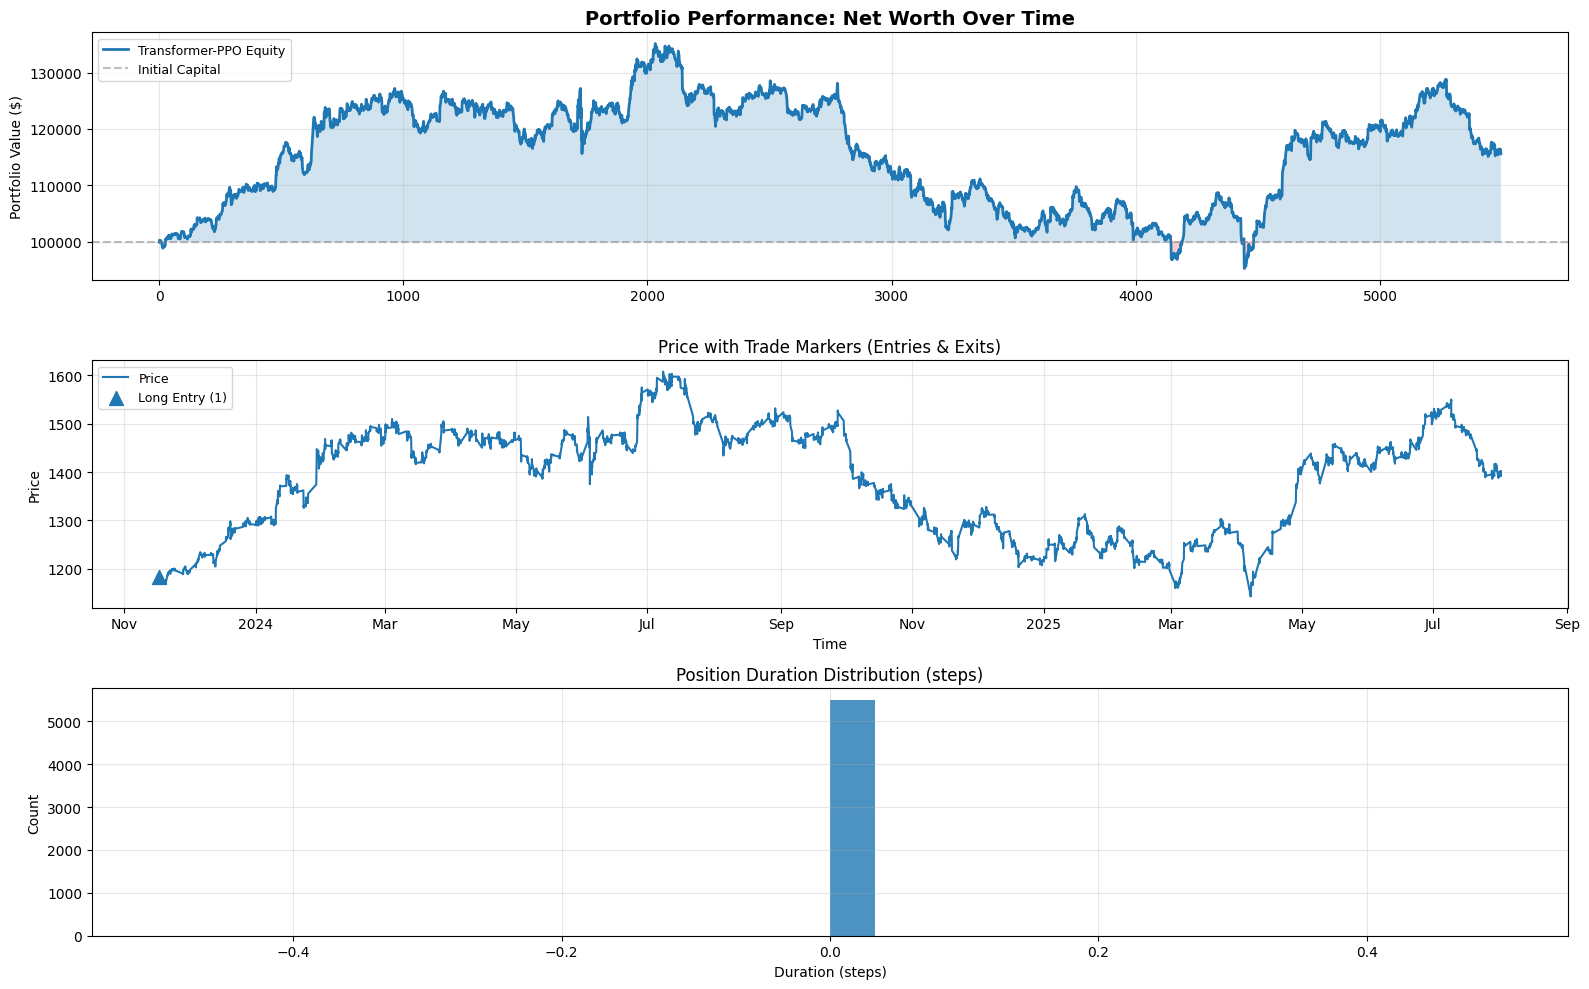

Done.


In [22]:
# save as transformer_ppo_swing.py and run: python transformer_ppo_swing.py
import math
import gymnasium as gym
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
from collections import deque

warnings.filterwarnings("ignore")
th.set_num_threads(1)


# ===================== 1. DATA PROCESSING =====================
def process_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = df.columns.str.strip().str.lower()
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values('timestamp').reset_index(drop=True)

    cols = ['open', 'high', 'low', 'close', 'volume']
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
    if 'close' not in df.columns:
        raise ValueError("CSV must contain 'close'")

    # Features
    df['log_ret'] = np.log(df['close'] / df['close'].shift(1))
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26

    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))

    df['sma20'] = df['close'].rolling(20).mean()
    df['std20'] = df['close'].rolling(20).std()
    df['bb_width'] = (df['std20'] * 4) / df['sma20']

    df = df.dropna().reset_index(drop=True)

    feature_cols = ['log_ret', 'macd', 'rsi', 'bb_width', 'volume']

    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size].copy().reset_index(drop=True)
    test_df = df.iloc[train_size:].copy().reset_index(drop=True)

    # Scaling
    std_feats = ['log_ret', 'macd', 'rsi', 'bb_width']
    std_scaler = StandardScaler()
    std_scaler.fit(train_df[std_feats])
    train_df[std_feats] = std_scaler.transform(train_df[std_feats])
    test_df[std_feats] = std_scaler.transform(test_df[std_feats])

    vol_train = np.log1p(train_df['volume'].values.reshape(-1, 1))
    vol_test = np.log1p(test_df['volume'].values.reshape(-1, 1))
    mm = MinMaxScaler(feature_range=(-1, 1))
    mm.fit(vol_train)
    train_df['volume'] = mm.transform(vol_train)[:, 0]
    test_df['volume'] = mm.transform(vol_test)[:, 0]

    return train_df, test_df, feature_cols


# ===================== 2. TRANSFORMER EXTRACTOR =====================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = th.zeros(max_len, d_model)
        position = th.arange(0, max_len, dtype=th.float32).unsqueeze(1)
        div_term = th.exp(th.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = th.sin(position * div_term)
        pe[:, 1::2] = th.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: seq_len x batch x emb
        seq_len = x.size(0)
        return x + self.pe[:seq_len]


class TransformerExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box,
                 features_dim: int = 128,
                 emb_dim: int = 64,
                 nhead: int = 4,
                 num_layers: int = 2,
                 dropout: float = 0.1):
        super().__init__(observation_space, features_dim)
        n_features, seq_len = observation_space.shape
        self.input_proj = nn.Linear(n_features, emb_dim)
        self.pos_enc = PositionalEncoding(emb_dim, max_len=seq_len + 10)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead,
                                                   dropout=dropout, batch_first=False)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(nn.Linear(emb_dim, features_dim), nn.ReLU())

    def forward(self, obs: th.Tensor) -> th.Tensor:
        # obs shape: (batch, n_features, seq_len)
        x = obs.float().permute(0, 2, 1)  # (batch, seq_len, n_features)
        x = self.input_proj(x)  # (batch, seq_len, emb_dim)
        x = x.permute(1, 0, 2)  # (seq_len, batch, emb_dim)
        x = self.pos_enc(x)
        x = self.transformer(x)
        x = x.mean(dim=0)  # (batch, emb_dim)
        return self.fc(x)


# ===================== 3. SWING TRADING ENV (LOG-REWARD & STRICter MASK) =====================
class SwingTradingEnv(gym.Env):
    """
    Gymnasium environment:
    - observations: (n_features, lookback_window) float32
    - actions: Discrete(3) 0=SHORT,1=NEUTRAL,2=LONG
    - rewards: log-portfolio return scaled *plus* bonuses/penalties
    Mask rules:
      - Prevent redundant repeated non-neutral trades (no buy-buy-buy or sell-sell-sell)
      - Enforce min_hold_period after entering a position
    """

    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, df, feature_cols, initial_balance=100000,
                 lookback_window=60, commission=0.001, min_hold_period=5, max_hold_period=20):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.feature_cols = feature_cols
        self.initial_balance = float(initial_balance)
        self.commission = float(commission)
        self.lookback_window = int(lookback_window)
        self.min_hold_period = int(min_hold_period)
        self.max_hold_period = int(max_hold_period)

        self.action_space = gym.spaces.Discrete(3)
        n_features = len(self.feature_cols)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf,
                                                shape=(n_features, self.lookback_window), dtype=np.float32)

        # runtime
        self.reset()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.lookback_window
        self.balance = float(self.initial_balance)
        self.shares = 0.0
        self.net_worth = float(self.initial_balance)
        self.last_trade = -9999
        self.position_steps = 0
        self.current_position = 1  # 1=neutral
        self.entry_price = 0.0

        self.recent_returns = deque(maxlen=50)
        self.history = {'net_worth': [], 'action': [], 'exec_price': [], 'positions': []}
        return self._get_obs(), {}

    def _get_obs(self):
        dfw = self.df.iloc[self.current_step - self.lookback_window:self.current_step]
        return dfw[self.feature_cols].values.T.astype(np.float32)

    def _get_current_pos(self):
        if self.shares > 0.01:
            return 2
        elif self.shares < -0.01:
            return 0
        else:
            return 1

    def valid_action_mask(self):
        """
        Return boolean mask (True allowed, False disallowed).
        Rules:
         - If currently LONG (2): disallow selecting LONG again (prevents buy-buy-buy)
           and disallow direct flip to SHORT (keep conservative). So only NEUTRAL allowed until exit.
         - If currently SHORT (0): disallow selecting SHORT again (prevents sell-sell-sell)
           and disallow direct flip to LONG. So only NEUTRAL allowed until exit.
         - If currently NEUTRAL (1): allow all actions.
         - Also enforce min_hold_period: if in position and haven't held min_hold_period, only allow staying in that
           position (i.e., no exit) — this makes agent hold for minimum time once entered.
        """
        mask = np.ones(self.action_space.n, dtype=bool)
        curr_pos = self._get_current_pos()
        steps_since_trade = self.current_step - self.last_trade

        if curr_pos == 2:
            # currently LONG: disallow repeating LONG trades and disallow going directly SHORT
            mask[2] = False  # cannot 'buy' again
            mask[0] = False  # no direct flip to short
            if steps_since_trade < self.min_hold_period:
                # must hold (i.e., only allow current position as no-op — we set mask so only neutral False)
                # but since repeating LONG is disallowed, we must allow NEUTRAL only after min_hold_period.
                # Before min_hold_period: enforce holding by disallowing neutral (so reselecting LONG is disallowed too).
                mask[:] = False
                mask[2] = True  # allow selecting the "stay in LONG" path (no new trade)
        elif curr_pos == 0:
            mask[0] = False  # cannot 'sell' again
            mask[2] = False  # no direct flip to long
            if steps_since_trade < self.min_hold_period:
                mask[:] = False
                mask[0] = True  # allow staying SHORT (no new trade)
        else:
            # NEUTRAL: allow all actions (enter long/short/stay neutral)
            mask[:] = True

        return mask

    def step(self, action):
        action = int(action)
        price = float(self.df['close'].iloc[self.current_step])
        prev_net_worth = float(self.net_worth)
        self.position_steps += 1

        mask = self.valid_action_mask()
        # If action not allowed, force nearest valid action (prefer neutral), and penalize small negative reward
        if not mask[action]:
            # Choose neutral if allowed else keep current position
            if mask[1]:
                action = 1
                penalty_for_invalid = -0.5
            else:
                action = self._get_current_pos()
                penalty_for_invalid = -0.5
        else:
            penalty_for_invalid = 0.0

        # Compute target shares (full equity sizing per design)
        if action == 2:
            target_shares = self.net_worth / price
        elif action == 0:
            target_shares = - (self.net_worth / price)
        else:
            target_shares = 0.0

        shares_diff = target_shares - self.shares
        exec_price = np.nan
        traded = False

        # Execute trade if needed
        if abs(shares_diff) > 1e-8:
            exec_price = price
            trade_value = abs(shares_diff) * exec_price
            cost = trade_value * self.commission
            # Update shares and balance
            self.shares += shares_diff
            self.balance -= shares_diff * exec_price
            self.balance -= cost
            self.last_trade = self.current_step
            self.position_steps = 0
            traded = True
            # Set entry price at entry
            if action in [0, 2]:
                self.entry_price = price

        # Update position trackers
        self.current_position = self._get_current_pos()
        self.net_worth = float(self.balance + (self.shares * price))

        # ========== REWARD (log-return base) ==========
        eps = 1e-8
        portfolio_log_ret = np.log((self.net_worth + eps) / (prev_net_worth + eps))
        # store for sharpe-like calculation
        self.recent_returns.append(portfolio_log_ret)

        # base reward: scaled log-return (percent-like magnitude)
        reward = float(portfolio_log_ret * 100.0)

        # Sharpe-like component (rolling)
        if len(self.recent_returns) >= 2:
            arr = np.array(self.recent_returns, dtype=float)
            mean_r = arr.mean()
            std_r = arr.std()
            sharpe_component = 0.0 if std_r < 1e-8 else float(np.clip(mean_r / (std_r + 1e-8), -2.0, 2.0))
            reward += float(sharpe_component * 0.5)

        # Downside penalty (Sortino-like)
        if portfolio_log_ret < 0:
            reward -= float(abs(portfolio_log_ret) * 50.0)

        # Strategic incentives: reward profitable exits
        if traded and action == 1:  # if trade caused an exit to neutral
            # prev_pos is the position before this step, approx by checking side of shares_diff sign
            # but we saved entry_price when entering, so use prev_pos based on sign of previous shares
            # We'll infer prev_pos from sign of (self.shares - shares_diff) -> previous shares
            prev_shares = self.shares - shares_diff
            if abs(prev_shares) > 1e-8 and self.entry_price > 0:
                if prev_shares > 0:
                    trade_return = (price - self.entry_price) / (self.entry_price + eps)
                else:
                    trade_return = (self.entry_price - price) / (self.entry_price + eps)

                if trade_return > 0:
                    reward += float(trade_return * 200.0)
                    # bonus if held within desired swing window
                    if self.min_hold_period <= (self.position_steps + 0) <= self.max_hold_period:
                        reward += 5.0
                else:
                    reward += float(trade_return * 100.0)

        # Penalty for overstaying
        if self.current_position in [0, 2] and self.position_steps > self.max_hold_period:
            over = self.position_steps - self.max_hold_period
            reward -= float(over * 0.5)

        # Penalty for excessive neutral holding
        if self.current_position == 1 and self.position_steps > 10:
            reward -= float(0.2 * (self.position_steps - 10))

        # Small entry bonus
        if traded and action in [0, 2]:
            reward += 2.0

        # Add minor penalty if agent tried an invalid action earlier
        reward += penalty_for_invalid

        # Final clip
        reward = float(np.clip(reward, -50.0, 50.0))

        # Advance
        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        truncated = False

        # Save history
        self.history['net_worth'].append(self.net_worth)
        self.history['action'].append(int(action))
        self.history['exec_price'].append(exec_price)
        self.history['positions'].append(self.shares)

        info = {
            'valid_mask': mask,
            'portfolio_log_return': portfolio_log_ret,
            'position_steps': self.position_steps,
            'traded': traded
        }

        return self._get_obs(), float(reward), bool(terminated), bool(truncated), info


# ===================== 4. TRAIN / EVAL / PLOTTING =====================
def train_and_evaluate(filename="reliance_30.csv",
                       total_timesteps=100_000,
                       lookback=60,
                       min_hold=3,
                       max_hold=20,
                       save_plot='Transformer_PPO_Swing_Results.png'):
    train_df, test_df, features = process_data(filename)

    # Train env (masked)
    base_env = SwingTradingEnv(train_df, features, lookback_window=lookback,
                               min_hold_period=min_hold, max_hold_period=max_hold)
    env = ActionMasker(base_env, lambda env: env.valid_action_mask())

    policy_kwargs = dict(
        features_extractor_class=TransformerExtractor,
        features_extractor_kwargs=dict(features_dim=128, emb_dim=64, nhead=4, num_layers=2, dropout=0.1),
    )

    model = MaskablePPO("MlpPolicy", env, policy_kwargs=policy_kwargs, verbose=1,
                        learning_rate=3e-4, n_steps=2048, batch_size=64, ent_coef=0.01)

    print(f"Starting training for {total_timesteps} timesteps...")
    model.learn(total_timesteps=total_timesteps)
    model.save("transformer_ppo_swing_model")
    print("Model saved: transformer_ppo_swing_model.zip")

    # --- EVALUATION ---
    eval_base = SwingTradingEnv(test_df, features, lookback_window=lookback,
                                min_hold_period=min_hold, max_hold_period=max_hold)
    eval_env = ActionMasker(eval_base, lambda env: env.valid_action_mask())

    obs, _ = eval_env.reset()
    net_worths = []
    actions = []
    exec_prices = []
    position_durations = []

    done = False
    step_i = 0
    while not done and step_i < (len(test_df) - lookback - 1):
        mask = eval_env.env.valid_action_mask()
        action, _ = model.predict(obs, action_masks=mask, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        net_worths.append(eval_env.env.net_worth)
        actions.append(int(action))
        exec_prices.append(eval_env.env.history['exec_price'][-1])
        position_durations.append(getattr(eval_env.env, 'position_steps', 0))
        done = bool(terminated or truncated)
        step_i += 1

    # ---------------- METRICS ----------------
    if len(net_worths) < 2:
        print("Not enough data in evaluation to compute metrics.")
        return

    nw = pd.Series(net_worths)
    # Portfolio log returns (evaluation)
    port_log_ret = np.log(nw / nw.shift(1)).dropna()
    total_ret = (nw.iloc[-1] - nw.iloc[0]) / nw.iloc[0] * 100.0
    # Annualization factor: keep same convention as earlier (sqrt(12*252))
    ann_factor = math.sqrt(12 * 252)
    sharpe = (port_log_ret.mean() / (port_log_ret.std() + 1e-8)) * ann_factor if port_log_ret.std() > 0 else 0.0
    negative = port_log_ret[port_log_ret < 0]
    sortino = (port_log_ret.mean() / (negative.std() + 1e-8)) * ann_factor if len(negative) > 0 else 0.0
    running_max = nw.cummax()
    drawdown = (nw - running_max) / running_max
    max_dd = drawdown.min() * 100.0
    win_rate = len(port_log_ret[port_log_ret > 0]) / len(port_log_ret) * 100.0 if len(port_log_ret) > 0 else 0.0

    trades_executed = int(np.sum(~pd.isna(exec_prices)))
    action_counts = pd.Series(actions).value_counts().to_dict()
    position_changes = int(np.sum(np.diff(actions) != 0))

    # Print small summary
    print("\n" + "=" * 60)
    print("EVALUATION SUMMARY")
    print("=" * 60)
    print(f"Final Net Worth    : ${nw.iloc[-1]:,.2f}")
    print(f"Total Return (pct) : {total_ret:.2f}%")
    print(f"Sharpe Ratio       : {sharpe:.4f}")
    print(f"Sortino Ratio      : {sortino:.4f}")
    print(f"Max Drawdown (pct) : {max_dd:.2f}%")
    print(f"Win Rate (pct)     : {win_rate:.2f}%")
    print(f"Trades Executed    : {trades_executed}")
    print(f"Position Changes   : {position_changes}")
    print("Action Distribution (steps):")
    print(f"  SHORT (0)  : {action_counts.get(0, 0)}")
    print(f"  NEUTRAL(1) : {action_counts.get(1, 0)}")
    print(f"  LONG  (2)  : {action_counts.get(2, 0)}")
    print("=" * 60)

    # ---------------- PLOTTING ----------------
    plt.style.use('default')
    fig = plt.figure(figsize=(16, 10))

    # Equity curve
    ax1 = plt.subplot(3, 1, 1)
    ax1.plot(nw.values, label='Transformer-PPO Equity', linewidth=2)
    ax1.axhline(y=nw.iloc[0], color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    ax1.fill_between(range(len(nw)), nw.iloc[0], nw.values,
                     where=np.array(nw) >= nw.iloc[0], alpha=0.2)
    ax1.fill_between(range(len(nw)), nw.iloc[0], nw.values,
                     where=np.array(nw) < nw.iloc[0], alpha=0.2, color='red')
    ax1.set_title('Portfolio Performance: Net Worth Over Time', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(alpha=0.3)

    # Price + trades
    ax2 = plt.subplot(3, 1, 2)
    hist_actions = np.array(actions)
    n_steps = len(hist_actions)
    start_idx = eval_env.env.lookback_window
    price_indices = np.arange(start_idx, start_idx + n_steps)
    prices_all = test_df['close'].values
    prices = prices_all[price_indices]

    prev_action = 1
    long_entries, short_entries, exits = [], [], []
    for i, act in enumerate(hist_actions):
        if i > 0:
            prev_action = hist_actions[i - 1]
        if act == 2 and prev_action != 2:
            long_entries.append(i)
        elif act == 0 and prev_action != 0:
            short_entries.append(i)
        elif act == 1 and prev_action in [0, 2]:
            exits.append(i)

    # Use timestamps if available
    if 'timestamp' in test_df.columns:
        x_vals = test_df['timestamp'].iloc[price_indices].values
        ax2.plot(x_vals, prices, label='Price', linewidth=1.5)
        if len(long_entries) > 0:
            x_long = test_df['timestamp'].iloc[price_indices[long_entries]].values
            ax2.scatter(x_long, prices[long_entries], marker='^', s=100, label=f'Long Entry ({len(long_entries)})', zorder=5)
        if len(short_entries) > 0:
            x_short = test_df['timestamp'].iloc[price_indices[short_entries]].values
            ax2.scatter(x_short, prices[short_entries], marker='v', s=100, label=f'Short Entry ({len(short_entries)})', zorder=5)
        if len(exits) > 0:
            x_exit = test_df['timestamp'].iloc[price_indices[exits]].values
            ax2.scatter(x_exit, prices[exits], marker='x', s=90, label=f'Exit ({len(exits)})', zorder=6)
        ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax2.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    else:
        ax2.plot(range(len(prices)), prices, label='Price', linewidth=1.5)
        if len(long_entries) > 0:
            ax2.scatter(long_entries, prices[long_entries], marker='^', s=100, label=f'Long Entry ({len(long_entries)})', zorder=5)
        if len(short_entries) > 0:
            ax2.scatter(short_entries, prices[short_entries], marker='v', s=100, label=f'Short Entry ({len(short_entries)})', zorder=5)
        if len(exits) > 0:
            ax2.scatter(exits, prices[exits], marker='x', s=90, label=f'Exit ({len(exits)})', zorder=6)

    ax2.set_title('Price with Trade Markers (Entries & Exits)')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Price')
    ax2.legend(loc='upper left', fontsize=9)
    ax2.grid(alpha=0.3)

    # Position duration histogram
    ax3 = plt.subplot(3, 1, 3)
    valid_durations = [d for d in position_durations if d is not None and d >= 0]
    if len(valid_durations) > 0:
        ax3.hist(valid_durations, bins=30, alpha=0.8)
    ax3.set_title('Position Duration Distribution (steps)')
    ax3.set_xlabel('Duration (steps)')
    ax3.set_ylabel('Count')
    ax3.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_plot, dpi=300, bbox_inches='tight')
    print(f"Saved plot: {save_plot}")
    plt.show()

    return {
        'net_worth_series': nw,
        'total_return_pct': total_ret,
        'sharpe': sharpe,
        'sortino': sortino,
        'max_dd_pct': max_dd,
        'win_rate_pct': win_rate,
        'trades_executed': trades_executed,
        'action_counts': action_counts
    }


if __name__ == "__main__":
    # MODIFY: change filename to the CSV you have
    filename = "reliance_30.csv"  # ensure this exists in the working dir
    results = train_and_evaluate(filename=filename,
                                 total_timesteps=100_000,
                                 lookback=60,
                                 min_hold=3,
                                 max_hold=250,
                                 save_plot='Transformer_PPO_Swing_Results.png')
    print("Done.")
